# DQN Agent training with Experience Replay and Fixed Q-Target

<div style="text-align: center; background-color:red; color: white; padding: 4px">This notebook runs in an installed environment as described in the `README.md` file.</div>

In this Jupyter notebook, we have implemented a DQN agent with an experience replay and a fixed Qtarget extension method. It is trained to solve the provided Unity's “Banana” environment. We used the PyTorch library to build the neural network and manage the training. The DQN agent uses an experiment memory to store transitions and a neural network to approximate the Q function. A fixed target is updated periodically to stabilize learning.

The constraints of the environment are as follows:
- The agent must collect yellow bananas while avoiding blue bananas.
- The agent receives a positive reward for each yellow banana collected and a negative reward for each blue banana collected.
- The agent must learn to navigate the environment to maximize its total reward.
- The agent has 300 time steps to collect the maximum number of yellow bananas, after which the interaction episode is indicated as "done" by the environment.

An episode is considered successful if the agent collects at least 13 bananas. The aim is to achieve a rolling average score of 13 or more over 100 episodes. Another (optional) challenge is to solve the “Banana” environment in less than 1800 episodes. In this notebook, we've added another constraint by considering that the shifted average over 100 episodes must be maintained over several episodes to consider the attainment of the objective as stable. We have also added the possibility of specifying stronger constraints on the maximum number of time steps available during an episode, and the number of episodes required to solve the environment.

The definitions of the DQN agent components (class `DQNAgentExpReplayFixedQTarget`) are included in separate files for better readability and modularity (see `README.md`), and called up in this notebook.

The notebook is divided into several sections:
1. **Library import**: We import the libraries needed to train the DQN agent.
2. **Parameter initialization and global function definitions**: we define global parameters and useful functions for this notebook.
3. **Agent training**: We define and use the `train_dqn_agent()` function, which trains the DQN agent on the “Banana” environment. This step can be skipped if the agent has already been trained, having a file of the underlying model weights, and we only wish to evaluate its performance.
4. **Agent evaluation**: We define and use the `eval_dqn_agent()` function to evaluate the agent's performance on the “Banana” environment.

> Note : Some parts of this notebook and the code included are inspired by code provided by Udacity as part of the “Deep Reinforcement Learning Nanodegree” course. We have taken care to respect good coding practices and to comment the code to facilitate understanding.

## Loading modules

Loading the necessary libraries.

In [1]:
# Built-in and 3rd party modules
from typing import List, Tuple
from collections import namedtuple
import random

import numpy as np
from unityagents import UnityEnvironment
from matplotlib import pyplot as plt, __version__ as mpl_version
%matplotlib inline
import torch
from tqdm import __version__ as tqdm_version
from tqdm.notebook import trange

# Custom modules
from dqn_agent__expreplay_fixedqtarget import DQNAgentExpReplayFixedQTarget as DQNAgent

Versions of the main modules used:

In [2]:
print("PyTorch version:", torch.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", mpl_version)
print("TQDM version:", tqdm_version)

PyTorch version: 2.4.1
NumPy version: 1.24.3
Matplotlib version: 3.7.5
TQDM version: 4.67.1


## Definitions and initializations

### Definitions

#### Global parameters

If necessary, we seed random engines for (hoping) reproducibility of results.

In [3]:
SEED = 71 # Set the random seed for reproducibility

if SEED is not None:
    random.seed(SEED)
    torch.manual_seed(SEED)
    np.random.seed(SEED)

We define hyperparameters useful for agent definition, training and evaluation. 

In addition, we strengthen the constraints on the maximum number of time steps available during an episode with `max_timesteps`, on the maximum number of episodes to solve the environment with `n_episodes_train`, and add the stability constraint to consider goal attainment as stable with `window_stability`.

In [4]:
MAX_TIMESTEPS_PROJECT = 300

# Agent neural netwotk settings
model_parameters = {
    "fc1_units": 64,
    "fc2_units": 64,
}

# Training hyperparameters
## Epsilon scheduler parameters
eps_end = 0.01
eps_decay = 0.995

n_episodes_train = 1500         # Maximum number of training episodes to solve the environment
max_timesteps = 275             # Max number of timesteps per episode. After 300 timestep the episode is done, as observed in the "Take Random Actions in the Environment" test
window_stability = 5            # Number of episodes to consider the agent learning as stable
avg_window_length_scores = 100  # Project success constraint
solution_threshold = 13         # Project success constraint
print_stats_each_n_episode = 25

weight_filename_prefix = f"model_weights_{max_timesteps}"

# Evaluation hyperparameters
n_episodes_test = 125

We define a special typing for episode statistics.

In [5]:
Episode_Stats = namedtuple("Experience", field_names=["i_episode", "steps_to_resolution", "score", "is_solution"])

We define a function for displaying statistics curves and scores obtained during learning or assessment.

In [6]:
def plot_episode_stats(
        episode_stats: List[Episode_Stats],
        score_avgs: List[float],
        shifted_score_avgs: List[float],
        solution_threshold: int,
        scores_window_length: int,
        max_timesteps: int,
        title: str=""
        ) -> None:
    """Display the training statistics in several plots.
    
    Args:
        episode_stats (List[Episode_Stats]): List of episode statistics.
        score_avgs (List[float]): List of score averages.
        shifted_score_avgs (List[float]): List of shifted score averages.
        solution_threshold (int): Threshold for a solution.
        scores_window_length (int): Length of the window score average.
        max_timesteps (int): Maximum number of timesteps by episode.
        title (str): Title for the plot.
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    scores = [episode.score for episode in episode_stats]
    # Plot the scores
    ax.plot(np.arange(1, len(scores)+1), scores, color="b", linewidth=.3, label="Scores")

    # Plot the score averages
    ax.plot(
        np.arange(1, len(score_avgs)+1),
        score_avgs,
        color="b",
        linestyle="--",
        label="Score average from start"
        )
    
    # Plot the shifted score averages (if available)
    if len(shifted_score_avgs) > 0:
        ax.plot(
            np.arange(scores_window_length, scores_window_length + len(shifted_score_avgs)),
            shifted_score_avgs,
            color="b",
            label=f"{scores_window_length} episodes shifted average"
            )
    
    # Plot the solution threshold line
    ax.axhline(y=solution_threshold, color="b", linestyle="-.", label="Solution threshold")
   
    ax.set_ylabel("Score")
    
    # Plot the successful episode stats
    x_scatter = []
    steps_scatter = []
    score_scatter = []
    steps_to_resolution_avgs = []
    for episode in episode_stats:
        if episode.is_solution:
            x_scatter.append(episode.i_episode)
            steps_scatter.append(episode.steps_to_resolution)
            score_scatter.append(episode.score)
        if len(x_scatter):
            steps_to_resolution_avgs.append(np.mean(steps_scatter))
            
    if len(x_scatter):
        ax.scatter(
            x_scatter,
            score_scatter,
            s=5,
            color="b",
            marker="o",
            label="Successful score"
        )
        
        ax2 = ax.twinx()
        ax2.scatter(
            x_scatter,
            steps_scatter,
            s=20,
            color="g",
            marker="x",
            label="Steps to success"
        )

        # Plot the average steps to success, from the first solution
        ax2.plot(
            np.arange(x_scatter[0], len(episode_stats)+1),
            steps_to_resolution_avgs,
            color="g",
            linestyle="--",
            label="Average steps to success from first success"
        )

        # Plot the solution threshold line
        ax2.axhline(y=max_timesteps, color="g", linestyle="-.", label="Max timesteps threshold")

        ax2.set_ylim(0, int(1.1 * MAX_TIMESTEPS_PROJECT))
        ax2.set_ylabel("Steps")

    # Display the figure with legend
    ax.set_xlabel("Episode #")
    plt.title(title)
    fig.legend(loc="lower right")
    plt.show()

We define a function to launch a Unity environment.

In [7]:
def launch_unity_env(
        file_name: str,
        train_mode: bool = False
        ) -> Tuple[UnityEnvironment, str, object]:
    """Launch the Unity environment.
    
    Args:
        file_name (str): Path to the Unity environment executable.
        train_mode (bool): Whether to launch in training mode or not.
    """
    env = UnityEnvironment(file_name)

    # Get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    env_info = env.reset(train_mode=train_mode)[brain_name]

    # Number of agents in the environment
    print('Number of agents:', len(env_info.agents))
    
    return env, brain_name, brain

### Initializations

#### Device

We'll use a GPU if available, otherwise the CPU. `mps` is Apple's GPU.

In [8]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
    )
print(f"Availabe device: {device}")

Availabe device: mps


We call up and initialize the Unity environment, using the indications provided in the provided `Navigation.ipynb` notebook, and retrieve the information needed to interact with the environment. This initialization can be used in this notebook for both training and evaluating the agent.

In [9]:
env, brain_name, brain = launch_unity_env("Banana.app", train_mode=True)

Mono path[0] = '/Users/me/Dropbox (Compte personnel)/Perso NG/Cours et Mooc/Udacity/Deep Reinforcement learning/Cours 2 - Value-Based Methods/Udacity Course 2 Project/Udacity Course 2 Project - Source/Banana.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/me/Dropbox (Compte personnel)/Perso NG/Cours et Mooc/Udacity/Deep Reinforcement learning/Cours 2 - Value-Based Methods/Udacity Course 2 Project/Udacity Course 2 Project - Source/Banana.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1


## Training the agent

We define the training function for a DQN agent on a Unity environment, with model weights saved at the end of training.

In [10]:
def train_dqn_agent(
        agent: DQNAgent,
        env: UnityEnvironment,
        brain_name: str,
        eps_scheduler: callable,
        eps_start: float = 1.0,
        n_max_episodes: int = 2000,
        solution_threshold: int = 13,
        avg_window_length_scores: int = 100,
        print_stats_each_n_episode: int = 25,
        window_stability: int = 1,
        max_timesteps: int = 300,
        weight_filename_prefix: str = "checkpoint", # None to not save weights
        ) -> Tuple[List[Episode_Stats], List[float], List[float]]:
    """Train the DQN agent in the environment.
    
    Args:
        agent (DQNAgentExpReplay): The DQN agent to train.
        env (UnityEnvironment): The Unity environment.
        brain_name (str): The name of the brain in the environment.
        eps_scheduler (function): Function to schedule epsilon.
        eps_start (float): Initial epsilon value.
        n_max_episodes (int): Number of episodes to train the agent.
        solution_threshold (int): Threshold for a solution.
        avg_window_length_scores (int): Length of the window score average.
        print_stats_each_n_episode (int): Frequency of printing stats.
        window_stability (int): Window length for stability check.
        max_timesteps (int): Maximum number of timesteps per episode.
        weight_filename_prefix (str): Prefix for saving weights. If None, weights are not saved. Filename will be suffixed with "_solved" or "_last_episode", the weights are saved when the environment is solved or at the end of training, respectively.

    Returns:
        tuple: A tuple containing:
            - stats_episodes (List[Episode_Stats]): List of episode statistics.
            - score_avgs (List[float]): List of mean scores.
            - shift_score_avgs (List[float]): List of shifted score averages.
    """
    # List of stats for each episode
    scores = []
    score_avgs = []
    shifted_score_avgs = []
    stats_episodes = []

    eps = eps_start             # Epsilon for exploration
    solved = False              # Flag to ind6icate if the environment is solved in the episode
    last_solved = 0             # Last episode indice where the environment was solved
    solved_episode_count = 0    # Count of episodes where the environment was solved
    shifted_score_avg = 0
    agent.train()
    for i_episode in trange(1, n_max_episodes+1, desc="Training", unit="episode", leave=False):
        # Reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        # Initial state
        state = env_info.vector_observations[0]

        score = 0               # episode score
        actions_of_episode = [] # list of actions taken during the episode
        steps_to_resolution = 0
        # Loop for each episode
        for i_step in range(1, max_timesteps+1):
            # Agent chooses action
            action = agent.act(state, eps=eps)
            actions_of_episode.append(action)
            
            # Apply action to environment and get environment evolution as
            # experience : next state, reward and done
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0] 
            
            score += reward
            if score >= solution_threshold and steps_to_resolution == 0:
                steps_to_resolution = i_step
            
            # Agent learns from the experience
            agent.step(state, action, reward, next_state, done)

            # Move to the next state
            state = next_state                
            
            # Check if episode is done (a.k.a terminal state)
            if done:
                break 
        
        # Save episode stats
        stats_episodes.append(
            Episode_Stats(i_episode, steps_to_resolution, score, score >= solution_threshold)
            )
        scores.append(score)
        score_avgs.append(np.mean(scores))
        
        if score >= solution_threshold:
            last_solved = i_episode
            solved_episode_count += 1

        # Print stats regularly
        if i_episode % print_stats_each_n_episode == 0:
            print(f'\rEpisode {i_episode} | Mean scores {score_avgs[-1]:.2f}' + \
                    f' | {avg_window_length_scores} shifted score average: {shifted_score_avg:.2f}' + \
                    f' | Environment solved {solved_episode_count} time(s).',
                    end=" ")
            if last_solved > 0:
                print(f'Last solution at episode {last_solved}th with score {stats_episodes[-1].score}.', end="")
                    
        # Process shifted score average when enough scores
        if i_episode >= avg_window_length_scores:
            shifted_score_avg = np.mean(scores[-avg_window_length_scores:])
            shifted_score_avgs.append(shifted_score_avg)

            # Check the stability of the solution
            if np.mean(shifted_score_avgs[-window_stability:]) >= solution_threshold:
                print(f'\n>> Environment solved in {i_episode} episodes!\t{avg_window_length_scores} shifted score average: {shifted_score_avg:.2f} stable')
                if weight_filename_prefix is not None:
                    filename = f"{weight_filename_prefix}_solved.pth"
                    agent.save(filename)
                    print(f"Model weights saved to {filename}")
                solved = True
                break

        # Update epsilon
        eps = eps_scheduler(i_step, eps)

    # Save the last episode if environment not solved
    if not solved:
        print(f'\n>> Environment not solved after {i_episode} episodes!\t{avg_window_length_scores} shifted score average: {shifted_score_avg:.2f} (perhaps > {solution_threshold} but not stable yet)')
        if weight_filename_prefix is not None:
            filename = f"{weight_filename_prefix}_last_episode.pth"
            agent.save(filename)
            print(f"\nModel weights saved to {filename}")

    return stats_episodes, score_avgs, shifted_score_avgs

We create an agent by specifying initialization parameters, and train it on the “Banana” environment using the `train_dqn_agent()` function. Note the creation of `eps_scheduler`, which must respect a particular interface (two input parameters `i_episode` and `eps`) to be compatible with the agent's training function.

In [11]:
# Instanciate the agent
agent = DQNAgent (
    state_size=brain.vector_observation_space_size,
    action_size=brain.vector_action_space_size,
    model_parameters=model_parameters,
    device=device
    )

# eps_scheduler : function to modify epsilon
# i_episode (based on 1) is the number of steps
# eps is the current epsilon
eps_scheduler = lambda i_episode, eps, : max(eps_end, eps_decay*eps)

# Train the agent
stats_episodes, score_avgs, shifted_score_avgs = train_dqn_agent(
    agent,
    env,
    brain_name,
    eps_scheduler,
    eps_start=1.0,
    n_max_episodes=n_episodes_train,
    max_timesteps=max_timesteps,
    avg_window_length_scores=avg_window_length_scores,
    solution_threshold=solution_threshold,
    window_stability=window_stability,
    print_stats_each_n_episode=print_stats_each_n_episode,
    weight_filename_prefix=weight_filename_prefix
)

I0000 00:00:1747516555.005065  637958 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


Training:   0%|          | 0/1500 [00:00<?, ?episode/s]

Episode 500 | Mean scores 6.47 | 100 shifted score average: 12.29 | Environment solved 74 time(s). Last solution at episode 498th with score 12.0.
>> Environment solved in 521 episodes!	100 shifted score average: 13.15 stable
Model weights saved to model_weights_f275_solved.pth


We display the stastics and score curves obtained during training.

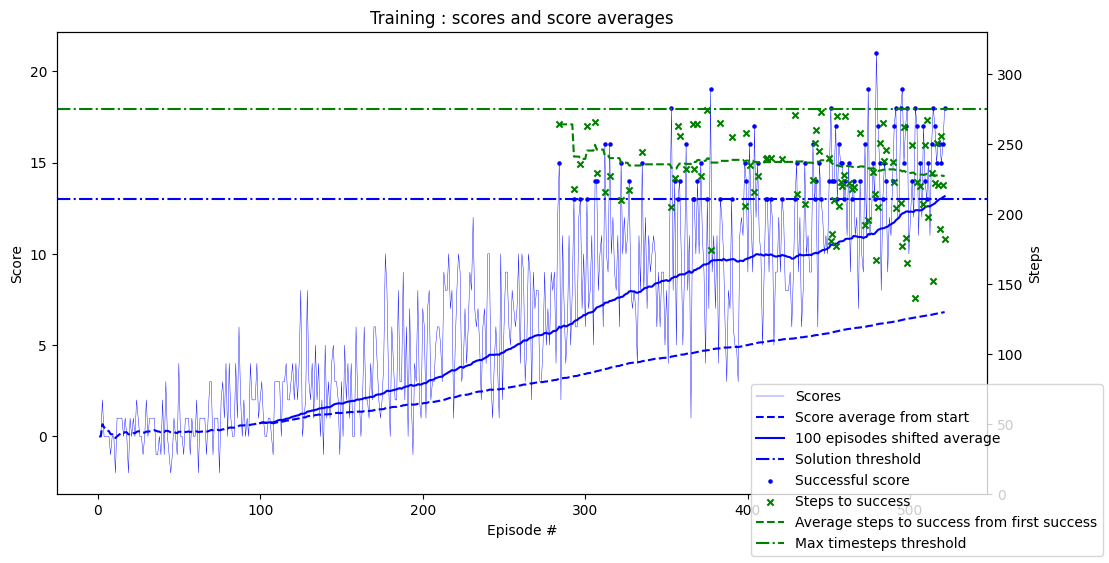

In [12]:
plot_episode_stats(
    stats_episodes, score_avgs, shifted_score_avgs, solution_threshold, 
    avg_window_length_scores, max_timesteps, "Training : scores and score averages"
    )

In addition to seeing that the agent has learned to solve the environment in “just” 521 episodes, we see that the average number of time steps needed to successfully complete an episode decreases.

## Agent evaluation

We evaluate the agent's performance on the “Banana” environment, then we display the training curves and the scores obtained during the test.

The evaluation can be carried out on the agent that has just been trained, or on an agent whose weights are available in a file.

In [13]:
weight_filename = f"{weight_filename_prefix}_solved.pth" # Prefix for saving weights
#weight_filename = "model_weights_last_episode.pth"
reload = True # Set to True to reload the last training weights
if reload:
    agent = DQNAgent(
        state_size=brain.vector_observation_space_size,
        action_size=brain.vector_action_space_size,
        model_parameters=model_parameters,
        device=device
        )
    agent.load(weight_filename)
agent.eval()

This step allows you to force the Unity environment window to be displayed, in preparation for any screen recordings for demonstration videos.

In [14]:
if env is None:
    env, brain_name, brain = launch_unity_env("Banana.app", train_mode=False)
else:
    env_info = env.reset(train_mode=False)[brain_name]

We define an agent evaluation function on a Unity environment.

In [15]:
def eval_dqn_agent(
        agent: DQNAgent,
        env: UnityEnvironment,
        brain_name: str,
        n_episodes_test: int = 100,
        solution_threshold: int = 13,
        avg_window_length_scores: int = 100,
    ) -> Tuple[List[Episode_Stats], List[float], List[float]]:
    """Evaluate the DQN agent in the environment.
    
    Args:
        agent (DQNAgent): The DQN agent to evaluate.
        env (UnityEnvironment): The Unity environment.
        brain_name (str): The name of the brain in the environment.
        n_episodes_test (int): Number of episodes to test the agent.
        solution_threshold (int): Threshold for a solution.
        avg_window_length_scores (int): Length of the window score average.

    Returns:
        tuple: A tuple containing:
            - stats_episodes (List[Episode_Stats]): List of episode statistics.
            - score_avgs (List[float]): List of mean scores.
            - shift_score_avgs (List[float]): List of shifted score averages.
    """
    scores = []
    stats_episodes = []
    score_avgs = []
    shifted_score_avgs = []

    score_avg = 0
    for i_episode in trange(1, n_episodes_test+1):
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations[0]
        
        score = 0    
        done = False
        steps_to_resolution = 0
        i_step = 0
        while not done:
            # Agent chooses action
            action = agent.act(state)
            
            # Apply action to environment
            env_info = env.step(action)[brain_name]
            
            # Get environment evolution as experience : next state, reward and done
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            state = next_state

            # Update the score
            score += reward
            i_step += 1
            if score >= solution_threshold and steps_to_resolution == 0:
                steps_to_resolution = i_step

            print(f"\rEpisode #{i_episode} : Score = {int(score)} in {i_step} steps | Score avg = {score_avg:.2f}", end=" ")

        # Save episode stats
        stats_episodes.append(
                Episode_Stats(i_episode, steps_to_resolution, score, score >= solution_threshold)
                )
        scores.append(score)
        score_avg = np.mean(scores)
        score_avgs.append(score_avg)
        
        # Process shifted score average when enough scores
        if i_episode >= avg_window_length_scores:
            shifted_score_avgs.append(np.mean(scores[-avg_window_length_scores:]))
            # Check the shifted score average stability
            print(f"| shifted avg score {shifted_score_avgs[-1]:.2f}", end="")
    
    print(f"\rEpisode #{i_episode} : Score = {int(score)} in {i_step} steps | Score avg = {score_avgs[-1]:.2f} | shifted avg score {shifted_score_avgs[-1]:.2f}")

    return stats_episodes, score_avgs, shifted_score_avgs

We launch the agent evaluation on the “Banana” environment.

In [17]:
eval_stats_episodes, eval_score_avgs, eval_shifted_score_avgs = eval_dqn_agent(
    agent,
    env,
    brain_name,
    n_episodes_test=n_episodes_test,
    solution_threshold=solution_threshold,
    avg_window_length_scores=avg_window_length_scores
)

  0%|          | 0/125 [00:00<?, ?it/s]

Episode #100 : Score = 14 in 300 steps | Score avg = 14.10  | shifted avg score 14.10
Episode #101 : Score = 4 in 300 steps | Score avg = 14.10  | shifted avg score 14.00
Episode #102 : Score = 2 in 300 steps | Score avg = 14.00  | shifted avg score 13.76
Episode #103 : Score = 23 in 300 steps | Score avg = 13.88  | shifted avg score 13.99
Episode #104 : Score = 1 in 300 steps | Score avg = 13.97  | shifted avg score 13.99
Episode #105 : Score = 15 in 300 steps | Score avg = 13.85  | shifted avg score 13.95
Episode #106 : Score = 16 in 300 steps | Score avg = 13.86  | shifted avg score 13.94
Episode #107 : Score = 3 in 300 steps | Score avg = 13.88  | shifted avg score 13.90
Episode #108 : Score = 20 in 300 steps | Score avg = 13.78  | shifted avg score 13.91
Episode #109 : Score = 20 in 300 steps | Score avg = 13.83  | shifted avg score 14.09
Episode #110 : Score = 18 in 300 steps | Score avg = 13.89  | shifted avg score 14.10
Episode #111 : Score = 17 in 300 steps | Score avg = 13.93

We then display the curves of the statistics and scores obtained during the evaluation :

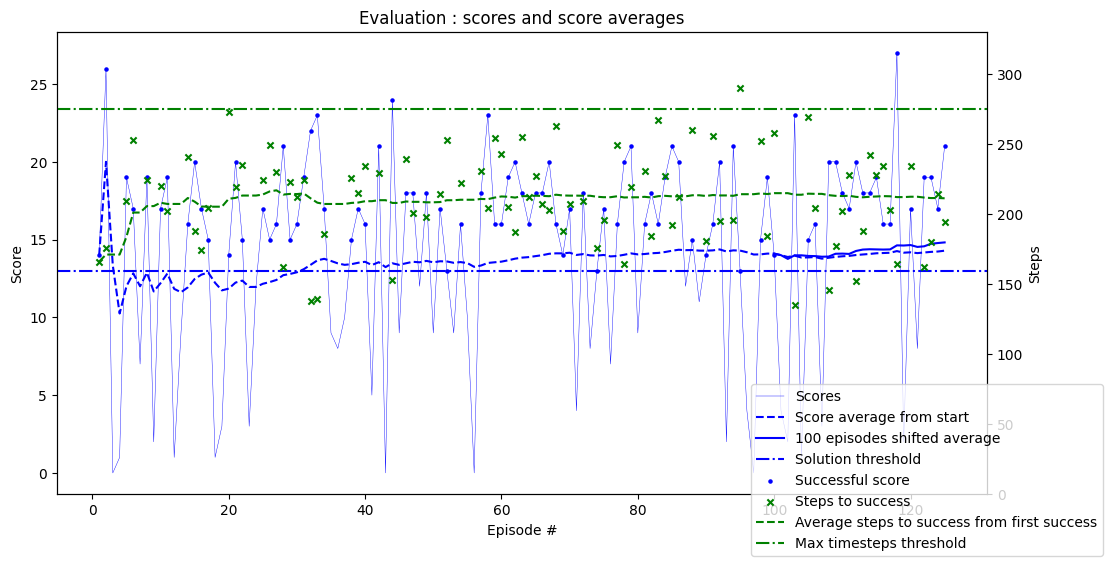

In [18]:
plot_episode_stats(
    eval_stats_episodes, eval_score_avgs, eval_shifted_score_avgs, solution_threshold,
    avg_window_length_scores, max_timesteps, "Evaluation : scores and score averages"
    )

In [19]:
successful_episodes = [episode for episode in eval_stats_episodes if episode.is_solution]
print(f"Number of successful episodes: {len(successful_episodes)} / {n_episodes_test} ({len(successful_episodes) / n_episodes_test * 100:.2f}%)")
successful_in_max_timesteps = [episode for episode in successful_episodes if episode.steps_to_resolution <= max_timesteps]
print(f"Number of successful episodes in less than {max_timesteps} timesteps: {len(successful_in_max_timesteps)} / {len(successful_episodes)} ({len(successful_in_max_timesteps) / len(successful_episodes) * 100:.2f}%)")

Number of successful episodes: 89 / 125 (71.20%)
Number of successful episodes in less than 275 timesteps: 88 / 89 (98.88%)


We note that the objectives set were achieved, even with tighter constraints on the number of episodes to solve the problem, the maximum number of time steps available per episode, as well as the stability of the rolling average over 100 episodes. We also note that even after 100 episodes, the rolling average is stable. In the end, only one successful episode fails to meet the constraint of the maximum number of time steps imposed.

On the other hand, a non-negligible proportion of episodes (~29%) are not solved, but these are offset by the high scores of the successful ones.

## End of notebook

We close the open Unity environment.

In [ ]:
env.close()
env = None